# Multi Layer Perceptron (MLP) の実装

# 目次

1. [全体像](#pipeline)
1. [目標](#goal)
- [下準備](#prepare)
- [活性化関数](#activate)
- [線形層](#linear)
- [多層パーセプトロン](#mlp)
- [学習](#train)

# 1. 全体像<a class="anchor" id="pipeline"></a>
- 変数のあとの括弧は，行列の形状 (numpy.ndarrayのshape) を表す．
- Nはバッチサイズ

※ バッチ処理とは……画像を1枚ずつ処理するのではなく，複数枚まとめて処理すること．画像1枚は，28×28のサイズから(784, )の形状をもつ1次元配列になるようにリサイズされているが，これをN枚まとめて(N, 784)の2次元配列として扱う．N枚まとめて行列演算を実行することで，1枚ずつ処理するより高速に処理できるようになる．

<img src="https://drive.google.com/uc?export=download&id=1q-o-iqPQ5gdDajty-sFNEJKYWRRXicW5">

## 2. 目標<a class="anchor" id="goal"></a>
- 多層 (例では3層) のニューラルネットワークを構築する．
- まず**活性化関数**をそれぞれ実装し，次に**線形層**の実装を行い，最後にそれらをまとめて**多層パーセプトロン**の実装を行う．
- 最終的には，下のように各レイヤーの入出力のユニット数と活性化関数を指定するだけでモデルが構築できるようにする．
- 例：3層・隠れ層のユニット数が1000．活性化関数はReLUを用いる場合
```python
model = MLP([Linear(784, 1000, ReLU),
                        Linear(1000, 1000, ReLU),
                        Linear(1000, 10, Softmax)])
```
- こうすると，4層以上への拡張や，活性化関数の変更などがしやすい

## 3. 下準備<a class="anchor" id="prepare"></a>

### ライブラリのインポート

- matplotlib: 図やグラフの描画など．
- numpy: 行列演算など
- sklearn: scikit-learn．様々な機械学習のモデルが利用できるが，今回はMNISTのデータをダウンロードするのに用いる．

In [0]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from __future__ import unicode_literals
from __future__ import print_function
from __future__ import division
from __future__ import absolute_import

In [3]:
from google.colab import drive # driveを接続
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [4]:
# drive中の課題ファイルのあるディレクトリに移動
%cd /content/gdrive/My Drive/handson20200512/ 

from test_mlp import *  # テスト用

/content/gdrive/My Drive/handson20200512


### MNISTデータの読み込み

- データをダウンロードする．一度ダウンロードすると，その後はデータを参照して読み込んでくれるので，毎回ダウンロードしなくても良くなる．
- Xが画像データ，Yが正解データ
- mnistのデータは，0~255のint型で表されているが，これを**255で割って正規化**する．

In [0]:
X, Y = fetch_openml('mnist_784', version=1, data_home="./data/", return_X_y=True)

In [0]:
X = X / 255.
Y = Y.astype("int")

### データセットの可視化

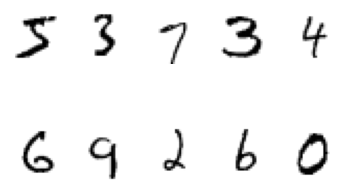

In [7]:
for i in range(10):
    plt.subplot(2, 5, i + 1)
    plt.imshow(X[i * 6500].reshape(28, 28), cmap='gray_r')
    plt.axis("off")

### 訓練・テストデータに分割

- 訓練データで学習し，同じ訓練データで性能の評価を行うと，訓練データでは良い性能を示すが，データを少しでも変えると性能が低下してしまうことがある（**過学習**）．
- <span style="text-decoration: underline">よって，学習する訓練データとは異なるテストデータで性能評価を行う</span>．

In [0]:
train_x, test_x, train_y, test_y = train_test_split(X, Y, test_size=0.2, random_state=2)
train_y = np.eye(10)[train_y].astype(np.int32)
test_y = np.eye(10)[test_y].astype(np.int32)
train_n = train_x.shape[0]
test_n = test_x.shape[0]

## 4. 活性化関数の実装<a class="anchor" id="activate"></a>

- ここでは，活性化関数として広く知られる Sigmoid関数と，ReLU関数，及び出力層の活性化関数であるSoftmax関数の実装を行う．
- 各関数の詳細については，講義スライドを参照

### <font color="crimson">課題</font>：Sigmoid関数の実装

- 順伝播計算

    - $h(x) = \sigma(x) = \dfrac{1}{1+e^{-x}}$

- 逆伝播計算

    - $h'(x) = \sigma'(x) = \sigma(x)\;(1-\sigma(x))$

※ 順伝播の $\sigma(x)$ と，逆伝播の $\sigma(x)$ は同じなので，2回計算しなくてもOK

<details>
    <summary>ヒント</summary>
    <div>
        <br>
        - np.exp(x) を用いて$\exp(x)$を計算できる
        <br>
        - 順伝播の計算結果は， self.y に保存されているので，逆伝播計算ではそれを使おう
    </div>
</details>

In [0]:
class Sigmoid:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        y =   # 順伝播計算
        self.y = y
        return y
    
    def backward(self):
        return   # 逆伝播計算

In [0]:
test_sigmoid(Sigmoid)

### ReLU関数

- 順伝播
    - $h(x) = \max(0, x)$
- 逆伝播
    - $h'(x) =
        \left\{ \begin{array}{ll}
            1 & (x > 0) \\
            0 & (x \leq 0) \\
        \end{array} \right.$

<details>
    <summary>ヒント</summary>
    <div>
        - ndarrayから，0より大きい要素をTrue, 0以下の要素をFalseとなるようなマスクを作成する
        <div>
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> a = np.array([[-1, 1], [0, 1]])
        >>> print(a)
        [[-1  1]
         [ 0  1]]
        >>> print(a > 0)
        [[False  True]
         [False  True]]
        >>> print(a * (a>0))
        [[0 1]
         [0 1]]
         </code></pre>
        </div>
    </div>
</details>

In [0]:
class ReLU:
    def __init__(self):
        self.x = None
        
    def __call__(self, x):
        self.x = x
        return   # 順伝播計算
    
    def backward(self):
        return   # 逆伝播計算

In [0]:
test_relu(ReLU)

### Softmax関数

- ロジスティック回帰と同様に実装する

- 入力：$\boldsymbol{X}=(\boldsymbol{x_1},\boldsymbol{x_2},\cdots,\boldsymbol{x_N})^T\in\mathbb{R}^{N\times K}$（データ行列）


- 出力：$\boldsymbol{Y}=(\boldsymbol{y_1},\boldsymbol{y_2},\cdots,\boldsymbol{y_N})^T\in\mathbb{R}^{N\times K},\,\,\,y_{nk} = softmax(\boldsymbol{x_n})_k$


- オーバーフローを防ぐために$\boldsymbol{x}_n$の最大値を$\boldsymbol{x}_n$自身から引く

$$
\begin{align}
softmax(\boldsymbol{x})_k&= \frac{\exp (x_{k})} {\Sigma_{i=1}^{K}{\exp (x_{i})}}=\frac{\exp (-x_{max})\exp (x_{k})}{\exp (-x_{max})\Sigma_{i=1}^{K}{\exp (x_{i})}}=\frac{\exp (x_{k}-x_{max})} {\Sigma_{i=1}^{K}{\exp (x_{i}-x_{max})}}
\end{align}
$$

<details>
    <summary>ヒント: 最大値の取得</summary>
    <div>
        - ndarrayから，最大値を取得したい
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A = np.array([[1, 2], [3, 4], [5, 6]])
        >>> print(A.shape)
        (3, 2)
        >>> A.max()
        6
        </code></pre>
        - ここでは，N×Kの配列について，1次元目の要素ごとに計N個の最大値を取得したい
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A.max(axis=1)
        array([2, 4, 6])
        </code></pre>
        - さらに，配列の形状はN×1にしておきたい
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A.max(axis=1, keepdims=True)
        array([[2],
       [4],
       [6]])
        </code></pre>
    </div>
</details>

In [0]:
class Softmax:
    def __init__(self):
        self.y = None
        
    def __call__(self, x):
        exp_x =   # ここで exp(x - x_max) を計算しよう
        y =  # exp_x を用いて softmax を計算しよう
        self.y = y
        return y

In [0]:
test_softmax(Softmax)

## 5. 線形層<a class="anchor" id="linear"></a>
- 引数
    - in_dim : 入力のユニット数
    - out_dim : 出力のユニット数
    - activation : 活性化関数
- 計算
    - 順伝播
        <div class="clearfix">
        <img style="float: left;" src="https://drive.google.com/uc?export=download&id=1cpmyxw8vSzLjwmMXgpWVTJrjrW3Nqzhh" width=200px>

        </div>
        - ヒント : np.dot(A, B)
    - 逆伝播
        - 入力 (dout)
            - 一つ上の層 (l+1層) からの出力 $(\boldsymbol{o}^{(l+1)})$
        - 誤差
        <div class="clearfix">
        <img style="float: left;" src="https://drive.google.com/uc?export=download&id=13fq5TC9KlwZ08qrpu5aYxPCL_XAT4AsZ" width=200px>
        </div>
            - $\odot$ は要素積
        - 勾配計算
        
        <div class="clearfix">
        <img style="float: left;" src="https://drive.google.com/uc?export=download&id=1_1FtLMvBMMgLJwKbuuRPWd_RLCFpo2p5" width=200px>
        </div>

<details>
    <summary>ヒント: 行列積の計算について</summary>
    <br>
    <div>
        $
A = \left(
    \begin{array}{ccc}
      0 & 1 & 2 \\
      1 & 2 & 3
    \end{array}
  \right)
$ , 
$
B = \left(
\begin{array}{cc}
  0 & 1\\
  1 & 2 \\
  2 & 3
\end{array}
\right)
$ としたとき， $C = AB$ を計算する例
        <br>
        <div>
        <div>
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A = np.array([[0, 1, 2], [1, 2, 3]])
        >>> B = np.array([[0, 1], [1, 2], [2, 3]])
        >>> print(A.shape, B.shape)
        (2, 3) (3, 2)
        >>> print(a > 0)
        [[False  True]
         [False  True]]
        >>> C = np.dot(A, B)
        >>> print(C)
        [[ 5  8]
         [ 8 14]]
         </code></pre>
          </div>
        </div>
    </div>
</details>

<details>
    <summary>ヒント: 行列の要素積</summary>
    <br>
    <div>
        <div>
        <pre style="background-color: whitesmoke;"><code style="background-color: whitesmoke;">
        >>> A = np.array([[0, 1], [2, 3]])
        >>> B = np.array([[1, 2], [3, 4]])
        >>> print(A*B)
        [[ 0  2]
         [ 6 12]]
         </code></pre>
        </div>
    </div>
</details>

In [0]:
class Linear:
    def __init__(self, in_dim, out_dim, activation):
        self.W = np.random.uniform(low=-0.08, high=0.08, size=(in_dim, out_dim))
        self.b = np.zeros(out_dim)
        self.activation = activation()
        self.delta = None
        self.x = None
        self.dW = None
        self.db = None

    def __call__(self, x):
        # 順伝播計算
        self.x = x
        u =   # self.W, self.b, x を用いて u を計算しよう
        self.z = self.activation(u)
        return self.z
    
    def backward(self, dout):
        # 誤差計算
        self.delta =  # dout と活性化関数の逆伝播 (self.activation.backward()) を用いて delta を計算しよう
        dout =  # self.delta, self.W を用いて 出力 o を計算しよう
        
        # 勾配計算
        self.dW =   # dW を計算しよう
        self.db =  # db を計算しよう
        
        return dout

In [0]:
test_linear(Linear, ReLU)

## 6. 多層パーセプトロンの実装<a class="anchor" id="mlp"></a>
- 今までに実装してきた活性化関数，Linear層を組み合わせて，多層のパーセプトロンを実装する．
- ここでは，先に実装したLinear層を組み合わせ，全体を通した**順伝播計算**と，**損失の計算**，**誤差逆伝播計算**，及び**重み・バイアスの更新**を実装する．
- 例：3層・隠れ層のユニット数が1000．活性化関数はReLUを用いる場合
```python
model = MLP([Linear(784, 1000, ReLU),
                        Linear(1000, 1000, ReLU),
                        Linear(1000, 10, Softmax)])
```
- **lr** : 学習率 (learning rate)．学習率とは，重み・バイアスの更新量を決定するハイパーパラメータ．つまり，パラメータ更新量 = 学習率 × 現在の勾配

### 全体像の再掲
<img src="https://drive.google.com/uc?export=download&id=11PBGMeAYpaeOtFH43FpEnrwZPbn8XbDf">

### <font color="crimson">課題</font> : 多層パーセプトロン

In [0]:
class MLP():
    def __init__(self, layers):
        self.layers = layers
        
    def train(self, x, t, lr):     
        # 1. 順伝播
        self.y = x
        for layer in self.layers:
            self.y =   # 順伝播計算を順番に行い， 出力 y を計算しよう
        
        # 2. 損失関数の計算
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        
        # 3. 誤差逆伝播
        # 3.1. 最終層
        # 3.1.1. 最終層の誤差・勾配計算
        batchsize = len(self.layers[-1].x)
        delta = (self.y - t) / batchsize
        self.layers[-1].delta = delta
        self.layers[-1].dW = np.dot(self.layers[-1].x.T, self.layers[-1].delta)
        self.layers[-1].db = np.dot(np.ones(batchsize), self.layers[-1].delta)
        dout = np.dot(self.layers[-1].delta, self.layers[-1].W.T)
        
        # 3.1.2. 最終層のパラメータ更新
        self.layers[-1].W -=  # self.layers[-1].dW を用いて最終層の重みを更新しよう
        self.layers[-1].b -=   # self.layers[-1].db を用いて最終層のバイアスを更新しよう
        
        # 3.2. 中間層
        for layer in self.layers[-2::-1]:
            # 3.2.1. 中間層の誤差・勾配計算
            dout =   # 逆伝播計算を順番に実行しよう
            
            # 3.2.2. パラメータの更新
            layer.W -=   # 各層の重みを更新
            layer.b -=   # 各層のバイアスを更新
            
        return self.loss

    def test(self, x, t):
        # 性能をテストデータで調べるために用いる
        # よって，誤差逆伝播は不要
        # 順伝播 (train関数と同様)
        self.y = x
        for layer in self.layers:
            self.y = layer(self.y)
        self.loss = np.sum(-t*np.log(self.y + 1e-7)) / len(x)
        return self.loss

## モデルの構築
- ここでは，図に示してきたような3層のニューラルネットワークを構築する
- 活性化関数はSigmoid関数とし， 隠れ層のニューロン数はいずれも1000とする．

In [0]:
model = MLP([Linear(784, 1000, Sigmoid),
                        Linear(1000, 1000, Sigmoid),
                        Linear(1000, 10, Softmax)])

# 7. 学習<a class="anchor" id="train"></a>

- n_epoch : エポック数．1エポックとは，学習時に訓練データをすべて学習した回数を表す．
- batchsize: バッチサイズ．
- lr: 学習率 (learning rate)．

In [0]:
n_epoch = 20
batchsize = 100
lr = 0.5

for epoch in range(n_epoch):
    print('epoch %d | ' % epoch, end="")
    
    # 訓練
    sum_loss = 0
    pred_y = []
    perm = np.random.permutation(train_n)
    
    for i in range(0, train_n, batchsize):
        x = train_x[perm[i: i+batchsize]]
        t = train_y[perm[i: i+batchsize]]
        sum_loss += model.train(x, t, lr) * len(x)
        # model.y には， (N, 10)の形で，画像が0~9の各数字のどれに分類されるかの事後確率が入っている
        # そこで，最も大きい値をもつインデックスを取得することで，識別結果を得ることができる
        pred_y.extend(np.argmax(model.y, axis=1))
    
    loss = sum_loss / train_n
    
    # accuracy : 予測結果を1-hot表現に変換し，正解との要素積の和を取ることで，正解数を計算できる．
    accuracy = np.sum(np.eye(10)[pred_y] * train_y[perm]) / train_n
    print('Train loss %.3f, accuracy %.4f | ' %(loss, accuracy), end="")
    
    
    # テスト
    sum_loss = 0
    pred_y = []
    
    for i in range(0, test_n, batchsize):
        x = test_x[i: i+batchsize]
        t = test_y[i: i+batchsize]
        
        sum_loss += model.test(x, t) * len(x)
        pred_y.extend(np.argmax(model.y, axis=1))

    loss = sum_loss / test_n
    accuracy = np.sum(np.eye(10)[pred_y] * test_y) / test_n
    print('Test loss %.3f, accuracy %.4f' %(loss, accuracy))

初期設定では，98%前後のaccuracyになったのではないかと思います．

ニューラルネットワークの学習には，様々なハイパーパラメータ（学習率など）を上手く設定する必要があります．

また，活性化関数や，重みの初期値の工夫，Dropoutなどのテクニックを用いることで，さらに性能が向上する可能性があります．

モデルを工夫して，よりよい性能を発揮するニューラルネットワークを構築してみましょう．